# Data Mining

In [4]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/content/qa-data-eng-analysis.csv')

# Convert dataset into a list of transactions (each row as a set of attributes)
transactions = df.apply(lambda row: [f"{col}={val}" for col, val in row.items()], axis=1).tolist()

# Convert to transaction format (binary matrix)
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

In [5]:
from mlxtend.frequent_patterns import apriori, association_rules

# Apply Apriori to find frequent itemsets
frequent_itemsets = apriori(df_encoded, min_support=0.2, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

# Sort rules by Lift (higher lift = stronger association)
rules = rules.sort_values(by="lift", ascending=False)

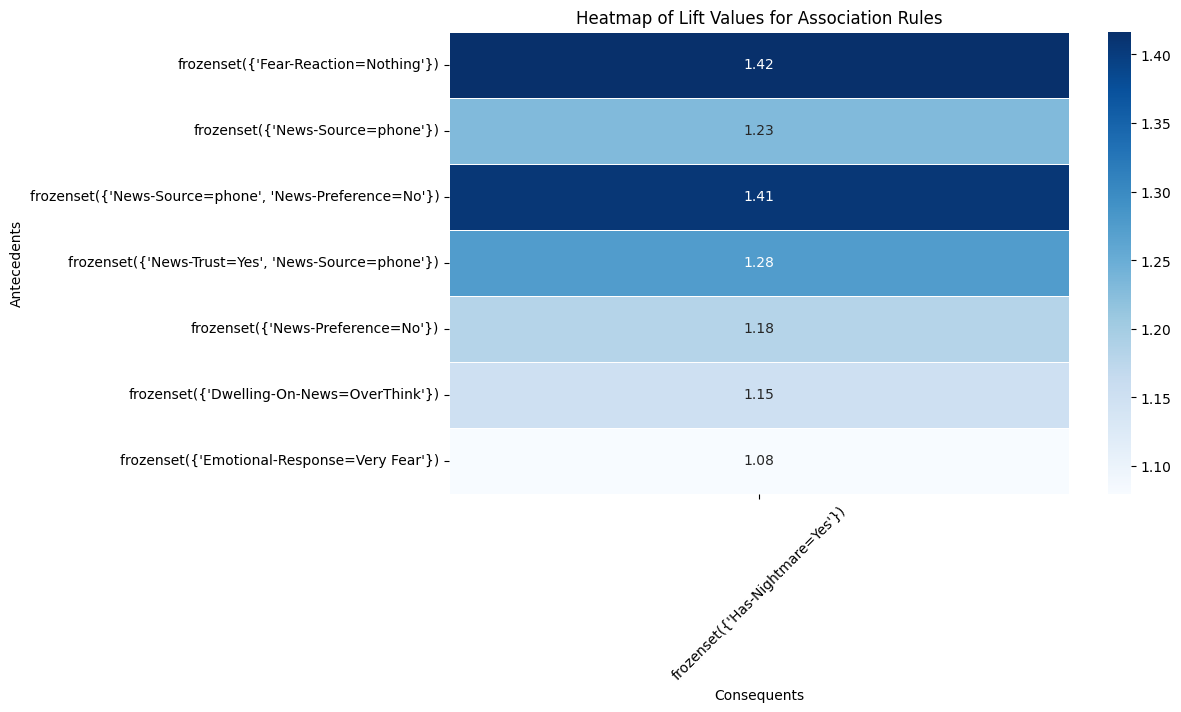

In [6]:
# Select top 10 rules for visualization
top_rules = rules.nlargest(10, 'lift')

# Pivot the table for heatmap (antecedents vs consequents)
heatmap_data = top_rules.pivot(index="antecedents", columns="consequents", values="lift")

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)
plt.title("Heatmap of Lift Values for Association Rules")
plt.ylabel("Antecedents")
plt.xlabel("Consequents")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


In [24]:
import networkx as nx
import pandas as pd
import plotly.graph_objects as go
import numpy as np

# Ensure 'rules' DataFrame exists from Apriori or FP-Growth
top_rules = rules.nlargest(10, 'lift')  # Top 10 rules based on Lift

G = nx.DiGraph()

# Add edges with weights
for _, row in top_rules.iterrows():
    antecedents = ', '.join(row['antecedents'])
    consequents = ', '.join(row['consequents'])
    lift_value = row['lift']
    G.add_edge(antecedents, consequents, weight=lift_value)

# Get positions using force-directed layout with SHORTER DISTANCES
# Reducing k value makes nodes closer together
pos = nx.spring_layout(G, seed=42, k=0.6)  # Decreased k for shorter links

# Extract node data
node_x, node_y, node_labels = [], [], []
for node, (x, y) in pos.items():
    node_x.append(x)
    node_y.append(y)
    node_labels.append(node)

# Extract edge data with prettier arrows
edge_traces = []
arrow_size = 0.02  # Arrow head size

for u, v in G.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]

    # Calculate arrow position (80% along the edge)
    arrow_x = x0 + 0.2*(x1-x0)
    arrow_y = y0 + 0.2*(y1-y0)

    # Calculate direction vector and normalize
    dx, dy = x1-x0, y1-y0
    length = np.sqrt(dx**2 + dy**2)
    dx, dy = dx/length, dy/length

    # Calculate perpendicular vector for arrow head
    px, py = -dy, dx

    # Edge line
    edge_trace = go.Scatter(
        x=[x0, x1],
        y=[y0, y1],
        line=dict(width=G[u][v]['weight']/2, color='rgba(50, 100, 150, 0.7)'),
        hoverinfo='text',
        text=f"{u} → {v}<br>Lift: {G[u][v]['weight']:.2f}",
        mode='lines'
    )
    edge_traces.append(edge_trace)

    # Arrow head
    arrow_trace = go.Scatter(
        x=[arrow_x-arrow_size*dx-arrow_size*px, arrow_x, arrow_x-arrow_size*dx+arrow_size*px],
        y=[arrow_y-arrow_size*dy-arrow_size*py, arrow_y, arrow_y-arrow_size*dy+arrow_size*py],
        line=dict(width=0),
        fill='toself',
        fillcolor='rgba(50, 100, 150, 0.7)',
        hoverinfo='none',
        mode='lines'
    )
    edge_traces.append(arrow_trace)

# Add colorful nodes with size based on degree and lift values
# Slightly reduced node size to maintain proportions in more compact layout
node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    text=node_labels,
    textposition="top center",
    textfont=dict(size=11, color='black', family='Arial, sans-serif'),
    hoverinfo='text',
    marker=dict(
        size=[np.sqrt(G.degree(n) + 1) * 12 for n in G.nodes()],  # Slightly reduced size
        color=[np.mean([G[u][v]['weight'] for u, v in G.edges() if u == n or v == n])
               if G.degree(n) > 0 else 1.0 for n in G.nodes()],
        colorscale='Viridis',
        opacity=0.85,
        line=dict(width=2, color='white')
    )
)

# Create Plotly figure
fig = go.Figure()

# Add all edge traces
for trace in edge_traces:
    fig.add_trace(trace)

# Add node trace
fig.add_trace(node_trace)

# Enhanced layout settings with increased width for screenshot
fig.update_layout(
    title={
        'text': "Association Rule Network Visualization",
        'font': {'size': 24, 'family': 'Arial, sans-serif', 'color': '#333333'},
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    showlegend=False,
    hovermode='closest',
    margin=dict(l=20, r=20, t=80, b=20),
    xaxis=dict(showgrid=False, zeroline=False, visible=False),
    yaxis=dict(showgrid=False, zeroline=False, visible=False),
    plot_bgcolor='rgba(245, 245, 245, 0.8)',
    width=800,  # Wider for better screenshot
    height=600,  # Taller for better screenshot
    annotations=[
        dict(
            text="Edge thickness represents lift value",
            showarrow=False,
            xref="paper", yref="paper",
            x=0.01, y=0.01,
            font=dict(size=12, color="#555555")
        )
    ]
)

# Add custom hover template for better tooltips
fig.update_traces(
    hovertemplate='<b>%{text}</b><extra></extra>',
    selector=dict(type='scatter')
)

# Add interactive features for better user experience
fig.update_layout(
    dragmode='pan',  # Enable panning
    modebar_add=['resetview', 'toimage'],  # Add useful buttons
)

# Show interactive plot
fig.show()
fig.write_html("association_rule_network_compact.html")


# Clustering

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Load dataset
df = pd.read_csv("/content/qa-data-eng-analysis.csv")

df["News-Preference"] = df["News-Preference"].replace("UnKown", np.nan)
num_missing = df["News-Preference"].isna().sum()
imputed_values = np.random.choice(["Yes", "No"], size=num_missing, p=[0.4, 0.6])
df.loc[df["News-Preference"].isna(), "News-Preference"] = imputed_values

df["News-Source"] = df["News-Source"].replace("UnKown", np.nan)
num_missing = df["News-Source"].isna().sum()
imputed_values = np.random.choice(["Tv", "School", "phone"], size=num_missing, p=[0.4, 0.5,0.1])
df.loc[df["News-Source"].isna(), "News-Source"] = imputed_values

# 2. One-Hot Encoding for Nominal Variables
nominal_cols = ["News-Source"]
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first')
nominal_encoded = onehot_encoder.fit_transform(df[nominal_cols])
nominal_encoded_df = pd.DataFrame(nominal_encoded, columns=onehot_encoder.get_feature_names_out(nominal_cols))

# 3. Ordinal Encoding for Ordered Variables
ordinal_cols = ["News-Trust", "News-Preference"]
for col in ordinal_cols:
    df[col] = LabelEncoder().fit_transform(df[col])  # Convert "No" -> 0, "Yes" -> 1

# 4. Merge Encoded Data with Original Data (Dropping Original Nominal Columns)
df_encoded = pd.concat([df.drop(columns=nominal_cols), nominal_encoded_df], axis=1)

# Display processed dataset
df_encoded.describe()

,News-Preference,News-Trust,News-Source_School,News-Source_Tv,News-Source_phone
count,75.00000,75.000000,75.000000,75.000000,75.000000
mean,0.44000,1.066667,0.066667,0.266667,0.533333
std,0.49973,0.977218,0.251124,0.445195,0.502247
min,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,2.000000,0.000000,0.000000,1.000000
75%,1.00000,2.000000,0.000000,1.000000,1.000000
max,1.00000,2.000000,1.000000,1.000000,1.000000


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Select only numerical columns for clustering
clustering_features = df_encoded.select_dtypes(include=["number"])

clustering_features.describe()

,News-Preference,News-Trust,News-Source_School,News-Source_Tv,News-Source_phone
count,75.00000,75.000000,75.000000,75.000000,75.000000
mean,0.44000,1.066667,0.066667,0.266667,0.533333
std,0.49973,0.977218,0.251124,0.445195,0.502247
min,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,2.000000,0.000000,0.000000,1.000000
75%,1.00000,2.000000,0.000000,1.000000,1.000000
max,1.00000,2.000000,1.000000,1.000000,1.000000


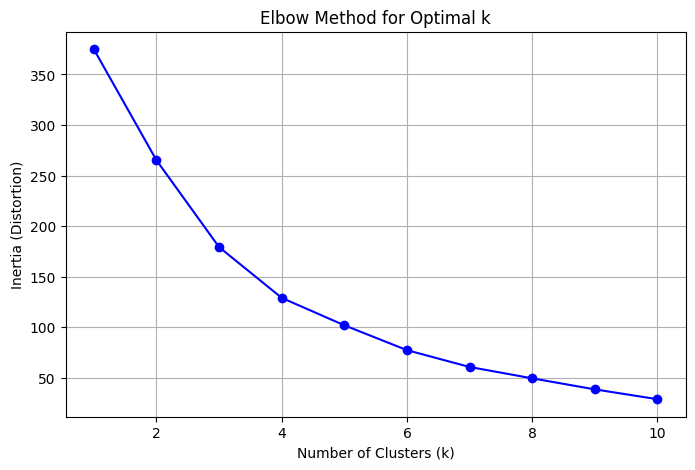

In [11]:
# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_features)

# Apply the Elbow Method to determine the optimal number of clusters
inertia = []
k_range = range(1, 11)  # Testing clusters from 1 to 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)  # Sum of squared distances to the closest cluster center

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker="o", linestyle="-", color="b")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Distortion)")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()

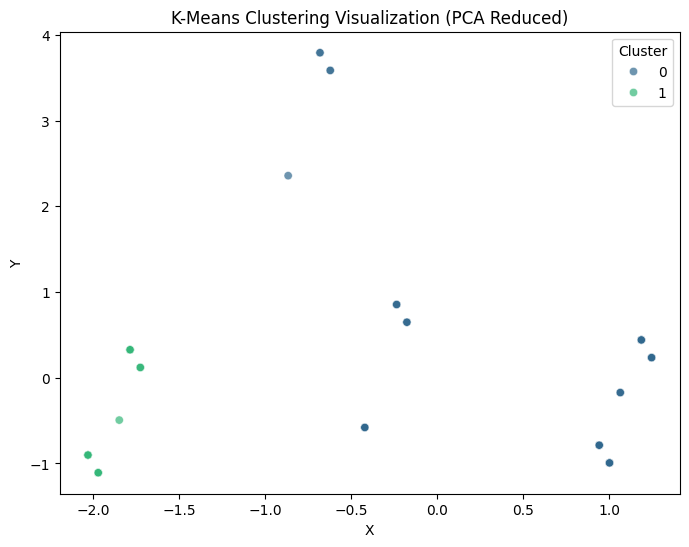

In [12]:
from sklearn.decomposition import PCA
import seaborn as sns

# Apply K-Means with the chosen number of clusters
optimal_k = 2  # Best k from the Elbow Method
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_encoded["Cluster"] = kmeans.fit_predict(scaled_data)  # Assign clusters

# Reduce dimensions using PCA for 2D visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
df_encoded["X"] = pca_result[:, 0]
df_encoded["Y"] = pca_result[:, 1]

# Scatter plot of clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x="X", y="Y", hue="Cluster", palette="viridis", data=df_encoded, alpha=0.7)
plt.title("K-Means Clustering Visualization (PCA Reduced)")
plt.show()

In [13]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import plotly.io as pio

# Set a professional theme for research paper
pio.templates.default = "plotly_white"

# Load the data
df = pd.read_csv('/content/qa-data-eng-analysis.csv')

# Replace 'UnKown' with np.nan for proper handling
df = df.replace('UnKown', np.nan)

# For clustering, we'll handle missing values by filling with the most frequent value
df_for_clustering = df.copy()
for col in df_for_clustering.columns:
    df_for_clustering[col] = df_for_clustering[col].fillna(df_for_clustering[col].mode()[0])

# One-hot encode the data
categorical_cols = df.columns  # All columns are categorical
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_data = encoder.fit_transform(df_for_clustering)
feature_names = encoder.get_feature_names_out(categorical_cols)

# Apply K-means with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(encoded_data)

# Add cluster labels to the original dataframe
df_clustered = df.copy()
df_clustered['Cluster'] = cluster_labels

# Rename clusters with meaningful names based on our analysis
cluster_names = {
    0: "Social Processors",
    1: "High Fear Phone Users",
    2: "Anxious Sharers",
    3: "Avoidant Copers"
}
df_clustered['Cluster_Name'] = df_clustered['Cluster'].map(cluster_names)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(encoded_data)

# Create a DataFrame with the reduced dimensions
pca_df = pd.DataFrame(data=reduced_data, columns=['PC1', 'PC2', 'PC3'])
pca_df['Cluster'] = cluster_labels
pca_df['Cluster_Name'] = pca_df['Cluster'].map(cluster_names)

# Add original features for hover information
for col in df.columns:
    pca_df[col] = df_clustered[col]

# 1. VISUALIZATION 1: 3D SCATTER PLOT OF CLUSTERS
# Create a 3D scatter plot with PCA components
fig_3d = px.scatter_3d(
    pca_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Cluster_Name',
    hover_data=['News-Source', 'Emotional-Response', 'Fear-Reaction', 'Has-Nightmare'],
    labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2', 'PC3': 'Principal Component 3'},
    title='News Response Patterns: Cluster Analysis (3D PCA Visualization)',
    color_discrete_sequence=px.colors.qualitative.G10
)

fig_3d.update_layout(
    scene=dict(
        xaxis_title='Principal Component 1',
        yaxis_title='Principal Component 2',
        zaxis_title='Principal Component 3'
    ),
    legend_title="Response Pattern Clusters",
    font=dict(family="Arial", size=12),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig_3d.write_html("news_response_3d_clusters.html")



# 3. VISUALIZATION 3: PARALLEL COORDINATES PLOT
# Create a parallel coordinates plot to visualize multidimensional patterns
# First, we need to convert categorical variables to numeric for parallel coordinates
df_parallel = df_clustered.copy()

# Create mappings for categorical variables
emotion_map = {'Normal': 0, 'Little Fear': 1, 'Sad': 2, 'Very Fear': 3}
nightmare_map = {'No': 0, 'Yes': 1}
dwelling_map = {'NoThinking': 0, 'Thinking': 1, 'OverThink': 2}
fear_reaction_map = {'Trying To Forget': 0, 'Talking with Dad': 1, 'Sharing Immediately': 2, 'Fear and Nothing': 3}
news_trust_map = {'No': 0, 'Yes': 1}
shares_news_map = {'No': 0, 'Yes': 1}

# Apply mappings
df_parallel['Emotional_Response_Num'] = df_parallel['Emotional-Response'].map(emotion_map)
df_parallel['Nightmare_Num'] = df_parallel['Has-Nightmare'].map(nightmare_map)
df_parallel['Dwelling_Num'] = df_parallel['Dwelling-On-News'].map(dwelling_map)
df_parallel['Fear_Reaction_Num'] = df_parallel['Fear-Reaction'].map(fear_reaction_map)
df_parallel['News_Trust_Num'] = df_parallel['News-Trust'].map(news_trust_map)
df_parallel['Shares_News_Num'] = df_parallel['Shares-News'].map(shares_news_map)

# Fill NaN values with mean for numeric columns
for col in ['Emotional_Response_Num', 'Nightmare_Num', 'Dwelling_Num',
            'Fear_Reaction_Num', 'News_Trust_Num', 'Shares_News_Num']:
    df_parallel[col] = df_parallel[col].fillna(df_parallel[col].mean())

# Create parallel coordinates plot
dimensions = [
    dict(range=[0, 1], label='Has Nightmare', values=df_parallel['Nightmare_Num']),
    dict(range=[0, 3], label='Emotional Response', values=df_parallel['Emotional_Response_Num']),
    dict(range=[0, 2], label='Dwelling on News', values=df_parallel['Dwelling_Num']),
    dict(range=[0, 3], label='Fear Reaction', values=df_parallel['Fear_Reaction_Num']),
    dict(range=[0, 1], label='News Trust', values=df_parallel['News_Trust_Num']),
    dict(range=[0, 1], label='Shares News', values=df_parallel['Shares_News_Num'])
]

fig_parallel = go.Figure(data=
    go.Parcoords(
        line=dict(
            color=df_parallel['Cluster'],
            colorscale=px.colors.qualitative.G10,
            showscale=True,
            colorbar=dict(title='Cluster')
        ),
        dimensions=dimensions,
        labelangle=30,
        labelfont=dict(size=12, family='Arial')
    )
)

fig_parallel.update_layout(
    title='Multi-dimensional Patterns in News Response Clusters',
    font=dict(family="Arial", size=12),
    margin=dict(l=80, r=80, b=20, t=40)
)

fig_parallel.write_html("news_response_parallel_coordinates.html")

# 4. VISUALIZATION 4: RADAR CHART FOR CLUSTER PROFILES
# Create a radar chart showing the profile of each cluster
# Compute mean values for each numeric feature by cluster
radar_data = df_parallel.groupby('Cluster_Name')[
    ['Nightmare_Num', 'Emotional_Response_Num', 'Dwelling_Num',
     'Fear_Reaction_Num', 'News_Trust_Num', 'Shares_News_Num']
].mean().reset_index()

# Normalize values to 0-1 scale for radar chart
for col in radar_data.columns[1:]:
    max_val = max(df_parallel[col])
    if max_val > 0:
        radar_data[col] = radar_data[col] / max_val

# Create radar chart
categories = ['Nightmares', 'Emotional Response', 'Dwelling',
              'Fear Reaction', 'News Trust', 'Shares News']

fig_radar = go.Figure()

for i, cluster in enumerate(radar_data['Cluster_Name']):
    fig_radar.add_trace(go.Scatterpolar(
        r=radar_data.iloc[i, 1:].values.tolist() + [radar_data.iloc[i, 1]],  # Close the loop
        theta=categories + [categories[0]],  # Close the loop
        fill='toself',
        name=cluster
    ))

fig_radar.update_layout(
    title='Psychological Profile of News Response Clusters',
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )
    ),
    showlegend=True,
    legend=dict(
        title="Cluster",
        orientation="h",
        yanchor="bottom",
        y=-0.2,
        xanchor="center",
        x=0.5
    ),
    font=dict(family="Arial", size=12),
    margin=dict(l=40, r=40, b=40, t=40)
)

fig_radar.write_html("news_response_radar_chart.html")

# 5. VISUALIZATION 5: HEATMAP OF CLUSTER CHARACTERISTICS
# Create a heatmap showing key characteristics of each cluster
# Prepare a pivoted dataframe for the heatmap
heatmap_data = pd.pivot_table(
    df_parallel,
    values=['Nightmare_Num', 'Emotional_Response_Num', 'Dwelling_Num',
            'Fear_Reaction_Num', 'News_Trust_Num', 'Shares_News_Num'],
    index=['Cluster_Name'],
    aggfunc='mean'
).reset_index()

# Create z values and labels for the heatmap
z_values = heatmap_data.iloc[:, 1:].values
x_labels = ['Nightmares', 'Emotional<br>Response', 'Dwelling', 'Fear<br>Reaction', 'News<br>Trust', 'Shares<br>News']
y_labels = heatmap_data['Cluster_Name'].tolist()

# Create heatmap
fig_heatmap = go.Figure(data=go.Heatmap(
    z=z_values,
    x=x_labels,
    y=y_labels,
    colorscale='YlGnBu',
    colorbar=dict(title='Intensity'),
    hoverongaps=False
))

fig_heatmap.update_layout(
    title='Intensity of Psychological Responses Across Clusters',
    xaxis=dict(title='Response Measures'),
    yaxis=dict(title='Cluster'),
    font=dict(family="Arial", size=12),
    margin=dict(l=40, r=40, b=20, t=40)
)

fig_heatmap.write_html("news_response_heatmap.html")

# 6. VISUALIZATION 6: BUBBLE CHART FOR NEWS SOURCE DISTRIBUTION
# Create a bubble chart to show news source distribution within clusters
bubble_data = pd.crosstab(
    df_clustered['Cluster_Name'],
    df_clustered['News-Source']
).reset_index().melt(id_vars=['Cluster_Name'], var_name='News_Source', value_name='Count')

fig_bubble = px.scatter(
    bubble_data,
    x="Cluster_Name",
    y="News_Source",
    size="Count",
    color="News_Source",
    color_discrete_sequence=px.colors.qualitative.Safe,
    hover_name="News_Source",
    size_max=60,
    title="News Source Distribution Across Response Clusters"
)

fig_bubble.update_layout(
    xaxis=dict(title='Response Pattern Cluster'),
    yaxis=dict(title='News Source'),
    legend_title="News Source",
    font=dict(family="Arial", size=12),
    margin=dict(l=40, r=40, b=40, t=40)
)

fig_bubble.write_html("news_source_bubble_chart.html")

# VISUALIZATION 7: SANKEY DIAGRAM (MOST PROFESSIONAL)
# Create a Sankey diagram to show flow between news source, emotional response, and clusters
# Prepare data for Sankey diagram
news_to_emotion = pd.crosstab(df_clustered['News-Source'], df_clustered['Emotional-Response'])
emotion_to_cluster = pd.crosstab(df_clustered['Emotional-Response'], df_clustered['Cluster_Name'])

# Create nodes
nodes = []
# News sources
news_sources = list(df_clustered['News-Source'].dropna().unique())
for news in news_sources:
    nodes.append({'name': f"Source: {news}"})

# Emotional responses
emotions = list(df_clustered['Emotional-Response'].dropna().unique())
for emotion in emotions:
    nodes.append({'name': f"Response: {emotion}"})

# Clusters
clusters = list(df_clustered['Cluster_Name'].unique())
for cluster in clusters:
    nodes.append({'name': f"Cluster: {cluster}"})

# Create links
links = []
# News Source to Emotional Response links
news_idx = {news: i for i, news in enumerate(news_sources)}
emotion_idx = {emotion: i + len(news_sources) for i, emotion in enumerate(emotions)}
cluster_idx = {cluster: i + len(news_sources) + len(emotions) for i, cluster in enumerate(clusters)}

# News Source to Emotion links
for news in news_sources:
    for emotion in emotions:
        if not pd.isna(news) and not pd.isna(emotion) and news_to_emotion.loc[news, emotion] > 0:
            links.append({
                'source': news_idx[news],
                'target': emotion_idx[emotion],
                'value': int(news_to_emotion.loc[news, emotion])
            })

# Emotion to Cluster links
for emotion in emotions:
    for cluster in clusters:
        if not pd.isna(emotion) and emotion_to_cluster.loc[emotion, cluster] > 0:
            links.append({
                'source': emotion_idx[emotion],
                'target': cluster_idx[cluster],
                'value': int(emotion_to_cluster.loc[emotion, cluster])
            })

# Create Sankey diagram
fig_sankey = go.Figure(data=[go.Sankey(
    node = dict(
        pad = 15,
        thickness = 20,
        line = dict(color = "black", width = 0.5),
        label = [node['name'] for node in nodes],
        color = ["rgba(31, 119, 180, 0.8)"] * len(news_sources) +
                ["rgba(255, 127, 14, 0.8)"] * len(emotions) +
                ["rgba(44, 160, 44, 0.8)"] * len(clusters)
    ),
    link = dict(
        source = [link['source'] for link in links],
        target = [link['target'] for link in links],
        value = [link['value'] for link in links],
        color = ["rgba(0, 0, 0, 0.2)"] * len(links)
    ))])

fig_sankey.update_layout(
    title_text="Flow from News Source through Emotional Response to Response Cluster",
    font=dict(family="Arial", size=12),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig_sankey.write_html("news_response_sankey.html")

# Generate a combined report in HTML with all visualizations
html_string = """
<!DOCTYPE html>
<html>
<head>
    <title>News Response Pattern Analysis</title>
    <style>
        body {font-family: Arial, sans-serif; max-width: 1200px; margin: 0 auto; padding: 20px;}
        h1 {color: #333; text-align: center;}
        h2 {color: #555; margin-top: 30px;}
        p {line-height: 1.6;}
        .viz-container {margin: 30px 0; border: 1px solid #ddd; padding: 20px; border-radius: 5px;}
        .viz-description {margin-bottom: 15px;}
    </style>
</head>
<body>
    <h1>News Response Pattern Analysis: Cluster Visualizations</h1>

    <p>This report presents visualizations of the cluster analysis performed on news response patterns data.
    The analysis identified four distinct clusters representing different psychological and behavioral responses to news.</p>

    <h2>Key Findings</h2>
    <p>Our analysis revealed four distinct response patterns:</p>
    <ul>
        <li><strong>Social Processors</strong>: Moderate fear, process news through social connections (especially family)</li>
        <li><strong>High Fear Phone Users</strong>: Strong emotional reactions, predominantly phone users, experience nightmares</li>
        <li><strong>Anxious Sharers</strong>: Fear news but actively share it, possibly as a coping mechanism</li>
        <li><strong>Avoidant Copers</strong>: Try to forget disturbing news, minimize emotional impact</li>
    </ul>

    <div class="viz-container">
        <h2>3D Cluster Visualization</h2>
        <div class="viz-description">
            <p>This 3D scatter plot shows the distribution of individuals across the four identified clusters,
            projected into a three-dimensional space using Principal Component Analysis (PCA).</p>
        </div>
        <iframe src="news_response_3d_clusters.html" width="100%" height="600px" frameborder="0"></iframe>
    </div>

    <div class="viz-container">
        <h2>Cluster Composition Hierarchy</h2>
        <div class="viz-description">
            <p>This sunburst chart reveals the hierarchical relationships between clusters, news sources, and emotional responses,
            highlighting the composition of each cluster.</p>
        </div>
        <iframe src="news_response_sunburst.html" width="100%" height="600px" frameborder="0"></iframe>
    </div>

    <div class="viz-container">
        <h2>Multi-dimensional Patterns</h2>
        <div class="viz-description">
            <p>This parallel coordinates plot allows for the visualization of patterns across multiple dimensions simultaneously,
            revealing how different psychological and behavioral measures relate within each cluster.</p>
        </div>
        <iframe src="news_response_parallel_coordinates.html" width="100%" height="600px" frameborder="0"></iframe>
    </div>

    <div class="viz-container">
        <h2>Psychological Profile of Clusters</h2>
        <div class="viz-description">
            <p>This radar chart displays the characteristic profile of each cluster across key psychological and behavioral measures,
            providing a clear visual comparison of the clusters.</p>
        </div>
        <iframe src="news_response_radar_chart.html" width="100%" height="600px" frameborder="0"></iframe>
    </div>

    <div class="viz-container">
        <h2>Response Intensity Heatmap</h2>
        <div class="viz-description">
            <p>This heatmap visualizes the intensity of different psychological responses across clusters,
            highlighting which responses are most characteristic of each cluster.</p>
        </div>
        <iframe src="news_response_heatmap.html" width="100%" height="500px" frameborder="0"></iframe>
    </div>

    <div class="viz-container">
        <h2>News Source Distribution</h2>
        <div class="viz-description">
            <p>This bubble chart illustrates the distribution of news sources within each cluster,
            with bubble size representing the relative frequency of each source.</p>
        </div>
        <iframe src="news_source_bubble_chart.html" width="100%" height="500px" frameborder="0"></iframe>
    </div>

    <div class="viz-container">
        <h2>News Response Flow (Sankey Diagram)</h2>
        <div class="viz-description">
            <p>This Sankey diagram visualizes the flow from news sources through emotional responses to final cluster classification,
            providing insight into the pathways of news impact.</p>
        </div>
        <iframe src="news_response_sankey.html" width="100%" height="700px" frameborder="0"></iframe>
    </div>

</body>
</html>
"""

with open("news_response_analysis_report.html", "w") as f:
    f.write(html_string)

# Generate a standalone visualization that would be most suitable for a research paper
# The Sankey diagram is often most informative for research papers, as it shows relationships clearly
print("Generated all visualizations. The Sankey diagram (news_response_sankey.html) and the 3D cluster visualization (news_response_3d_clusters.html) are particularly suitable for research papers.")

Generated all visualizations. The Sankey diagram (news_response_sankey.html) and the 3D cluster visualization (news_response_3d_clusters.html) are particularly suitable for research papers.
